<a href="https://colab.research.google.com/github/pbonillor/DATA_SCIENCE_CON_PYTHON/blob/main/FindingNemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación de las librerías necesarias
!pip install -q fiftyone ultralytics requests beautifulsoup4 albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 717.5 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.1/869.1 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:0

In [ ]:
# Importación de librerías
import requests
import os
import fiftyone as fo
import fiftyone.utils.random as four
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from google.colab import files
from IPython.display import Image, display
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

Descargando imágenes para: pez payaso real solo


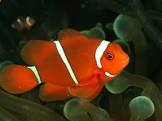

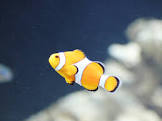

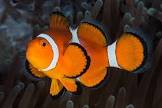

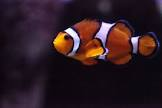

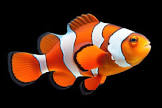

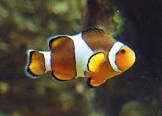

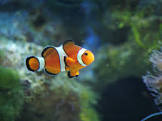

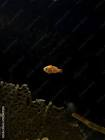

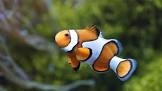

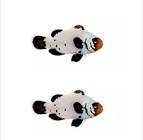

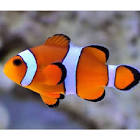

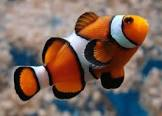

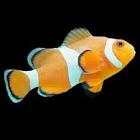

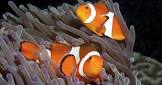

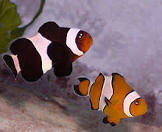

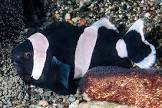

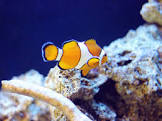

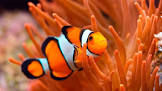

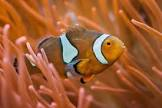

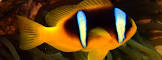

Descargando imágenes para: A live clownfish alone


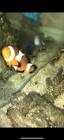

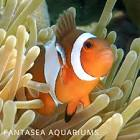

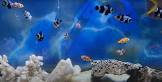

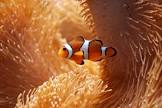

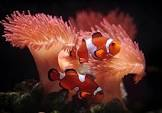

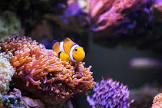

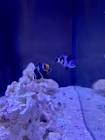

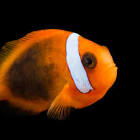

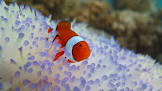

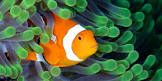

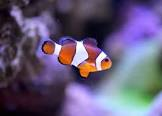

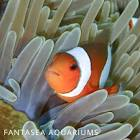

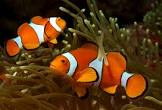

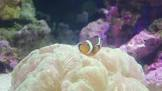

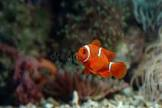

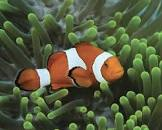

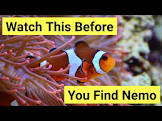

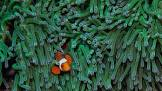

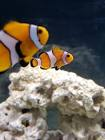

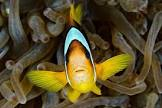

In [ ]:
# Definimos las clases y sus categorías, además de las constantes
class_objetive = {
    "nemo": ["pez payaso real solo", "A live clownfish alone"]
}
NUM_IMAGES = 200  # Aumentar el número de imágenes para una mejor diversidad
FOLDER_CLASS = "images"

# Función para obtener las URLs de las imágenes
def get_image_urls(query, num_images=NUM_IMAGES):
    search_url = f"https://www.google.com/search?q={query}&tbm=isch"
    response = requests.get(search_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    images = soup.find_all('img', limit=num_images)

    image_urls = [urljoin(search_url, img['src']) for img in images
                 if 'src' in img.attrs and
                 not any(keyword in img['src'] for keyword in ["google", "logos"])]
    return image_urls

# Función para descargar las imágenes y mostrarlas
def download_and_display_images(query, category):
    path_class = FOLDER_CLASS+"/"+category
    if not os.path.exists(path_class):
        os.makedirs(path_class)
    image_urls = get_image_urls(query)
    for idx, img_url in enumerate(image_urls):
        try:
            img_data = requests.get(img_url).content
            img_filename = os.path.join(path_class, f"{query.replace(' ', '_')}_{idx+1}.jpg")
            with open(img_filename, 'wb') as handler:
                handler.write(img_data)
            display(Image(img_filename))
        except Exception as e:
            print(f"Could not download {img_url}: {e}")

# Realizar scraping para cada tipo de clase
for category, queries in class_objetive.items():
    for query in queries:
        print(f"Descargando imágenes para: {query}")
        download_and_display_images(query, category)

In [ ]:
# Definir la aumentación de datos
augmentation = A.Compose([
    A.LongestMaxSize(max_size=512),  # Redimensionar las imágenes manteniendo la relación de aspecto
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),  # Rellenar las imágenes hasta 512x512
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(width=512, height=512),
    ToTensorV2()
])

def apply_augmentation(image_path):
    image = cv2.imread(image_path)
    augmented = augmentation(image=image)
    return augmented['image']

In [ ]:
# Directorio donde están las imágenes organizadas por clases
images_dir = "images/"

# Obtener los nombres de las carpetas como clases
classes = [class_name for class_name in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, class_name))]

# Crear un dataset en FiftyOne
dataset = fo.Dataset(name="ImagesNemo")

# Iterar sobre las carpetas de clases y agregar las muestras al dataset
for class_name in classes:
    class_dir = os.path.join(images_dir, class_name)
    if os.path.isdir(class_dir):
        samples = []
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Asegurarse de que son archivos de imagen
                filepath = os.path.join(class_dir, filename)
                # Aplicar aumentación de datos
                augmented_image = apply_augmentation(filepath)
                # Crear muestra con clasificación
                sample = fo.Sample(filepath=filepath, classes=fo.Classification(label=class_name))
                samples.append(sample)
        dataset.add_samples(samples, expand_schema=True)

# Guardar el dataset (opcional)
dataset.persistent = True
dataset.save()

# Cargar el dataset
dataset = fo.load_dataset("ImagesNemo")

# Eliminar etiquetas existentes para empezar de nuevo
dataset.untag_samples(dataset.distinct("tags"))

# Dividir en entrenamiento, validación y prueba
four.random_split(
    dataset,
    {"train": 0.8, "val": 0.1, "test": 0.1}
)

 100% |███████████████████| 40/40 [101.7ms elapsed, 0s remaining, 393.3 samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 40/40 [101.7ms elapsed, 0s remaining, 393.3 samples/s] 


In [ ]:
def export_yolo_data(
    samples,
    export_dir,
    classes,
    label_field="classes",
    split=None
):
    if type(split) == list:
        splits = split
        for split in splits:
            export_yolo_data(
                samples,
                export_dir,
                classes,
                label_field,
                split
            )
    else:
        if split is None:
            split_view = samples
            split = "val"
        else:
            split_view = samples.match_tags(split)

        split_view.export(
            export_dir=export_dir,
            dataset_type=fo.types.YOLOv5Dataset,
            label_field=label_field,
            classes=classes,
            split=split
        )

# Exportar en formato YOLO
export_yolo_data(
    dataset,
    "ImagesNemo",
    classes,
    label_field="classes",
    split=["train", "val", "test"]
)

Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Classification'>. Converting field 'classes' to detections whose bounding boxes span the entire image...


INFO:fiftyone.utils.data.exporters:Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Classification'>. Converting field 'classes' to detections whose bounding boxes span the entire image...


 100% |███████████████████| 32/32 [98.0ms elapsed, 0s remaining, 326.6 samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 32/32 [98.0ms elapsed, 0s remaining, 326.6 samples/s] 


Directory 'ImagesNemo' already exists; export will be merged with existing files


Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Classification'>. Converting field 'classes' to detections whose bounding boxes span the entire image...


INFO:fiftyone.utils.data.exporters:Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Classification'>. Converting field 'classes' to detections whose bounding boxes span the entire image...


 100% |█████████████████████| 4/4 [47.6ms elapsed, 0s remaining, 84.1 samples/s] 


INFO:eta.core.utils: 100% |█████████████████████| 4/4 [47.6ms elapsed, 0s remaining, 84.1 samples/s] 


Directory 'ImagesNemo' already exists; export will be merged with existing files


Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Classification'>. Converting field 'classes' to detections whose bounding boxes span the entire image...


INFO:fiftyone.utils.data.exporters:Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Classification'>. Converting field 'classes' to detections whose bounding boxes span the entire image...


 100% |█████████████████████| 4/4 [40.3ms elapsed, 0s remaining, 99.3 samples/s] 


INFO:eta.core.utils: 100% |█████████████████████| 4/4 [40.3ms elapsed, 0s remaining, 99.3 samples/s] 


In [ ]:
# Ahora entrenamos el modelo YOLOv8
!yolo task=detect mode=train model=yolov8l.pt data=ImagesNemo/dataset.yaml epochs=100 imgsz=512 batch=16 optimizer=Adam

100% 83.7M/83.7M [00:00<00:00, 112MB/s]
Ultralytics YOLOv8.2.80 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=ImagesNemo/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

In [ ]:
# Realizar predicciones con los "mejores" pesos encontrados durante el entrenamiento
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source=ImagesNemo/images/test save_txt=True save_conf=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 807, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 143, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 295, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 855, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 781, in torch_safe_load
    ckpt = torch.load(fi

In [ ]:
!git clone https://github.com/mikel-brostrom/yolo_tracking.git  # Clonar repositorio
%cd yolo_tracking
!pip install -v -e .
%cd ..

import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.3.1+cu121 (CPU)


In [ ]:
# Obtener el video para la detección
!wget -nc https://github.com/pbonillor/IA_GENERATIVA_CON_PYTHON/raw/main/payaso.mp4

--2024-08-23 02:00:10--  https://github.com/pbonillor/IA_GENERATIVA_CON_PYTHON/raw/main/payaso.mp4
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pbonillor/IA_GENERATIVA_CON_PYTHON/main/payaso.mp4 [following]
--2024-08-23 02:00:10--  https://raw.githubusercontent.com/pbonillor/IA_GENERATIVA_CON_PYTHON/main/payaso.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9026075 (8.6M) [application/octet-stream]
Saving to: ‘payaso.mp4’

payaso.mp4          100%[===================>]   8.61M  --.-KB/s    in 0.1s    

2024-08-23 02:00:11 (65.3 MB/s) - ‘payaso.mp4’ saved [9026075/9026075]



In [ ]:
# Desinstalar versiones anteriores de ultralytics si es necesario
%pip uninstall ultralytics

Found existing installation: ultralytics 8.2.80
Uninstalling ultralytics-8.2.80:
  Would remove:
    /usr/local/bin/ultralytics
    /usr/local/bin/yolo
    /usr/local/lib/python3.10/dist-packages/tests/*
    /usr/local/lib/python3.10/dist-packages/ultralytics-8.2.80.dist-info/*
    /usr/local/lib/python3.10/dist-packages/ultralytics/*
Proceed (Y/n)? 

In [ ]:
!mv runs/detect/train/weights/best.pt yolov8_findingnemo.pt

In [ ]:
!python yolo_tracking/tracking/track.py --yolo-model yolov8_findingnemo.pt --reid-model mobilenetv2_x1_4_dukemtmcreid.pt --source payasocorto.mp4 --save --project runs/track --conf 0.97 --iou 0.30 --imgsz 640


In [ ]:
# Convertir el archivo de salida a MP4
!ffmpeg -y -i runs/track/exp/pezpayasocorto.avi -t 25 -vf fps=30 -vcodec libx264 findingnemo.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('findingnemodoris.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()